# __어플평점 4점을 넘기위해 고려해야 할 사항은 무엇인가?__

### 데이터 선정이유 및 문제정의

In [ ]:
# 필요한 라이브러리들
import pandas as pd
import numpy as np
import graphviz
import sklearn
import xgboost

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn import tree

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from xgboost import XGBRegressor

from pandas_profiling import ProfileReport

from pdpbox import pdp, get_dataset, info_plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps

# Data collection date (from API); July 2017

# How does the App details contribute the user ratings?
# Try to compare app statistics for different groups?

data = pd.read_csv('AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [ ]:
data.shape

(7197, 17)

In [ ]:
# Currency에 다른 통화 유무 체크
data['currency'].unique()

array(['USD'], dtype=object)

In [ ]:
# Unnames: 0의 중복값여부체크 # 목차와 동일하다 판단.
data.duplicated('vpp_lic').sort_values(ascending=True)

0       False
42      False
4804     True
4803     True
4802     True
        ...  
2393     True
2392     True
2391     True
2473     True
7196     True
Length: 7197, dtype: bool

In [ ]:
# 불필요한 컬럼 삭제
data = data.drop(['currency','Unnamed: 0', 'id','user_rating_ver', 'rating_count_ver'],axis=1)
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6.3.5,4+,Games,38,5,10,1
1,Evernote - stay organized,158578688,0.00,161065,4.0,8.2.2,4+,Productivity,37,5,23,1
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5.0.0,4+,Weather,37,5,3,1
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5.10.0,12+,Shopping,37,5,9,1
4,Bible,92774400,0.00,985920,4.5,7.5.1,4+,Reference,37,5,45,1


In [ ]:
data.shape

(7197, 12)

In [ ]:
# 중복값여부체크
data.drop_duplicates()
data.shape

(7197, 12)

In [ ]:
# 결측치 유무확인
data.isnull().sum().sort_values(ascending=True)
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6.3.5,4+,Games,38,5,10,1
1,Evernote - stay organized,158578688,0.00,161065,4.0,8.2.2,4+,Productivity,37,5,23,1
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5.0.0,4+,Weather,37,5,3,1
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5.10.0,12+,Shopping,37,5,9,1
4,Bible,92774400,0.00,985920,4.5,7.5.1,4+,Reference,37,5,45,1


In [ ]:
data.head(5)

,track_name,size_bytes,price,rating_count_tot,user_rating,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6.3.5,4+,Games,38,5,10,1
1,Evernote - stay organized,158578688,0.00,161065,4.0,8.2.2,4+,Productivity,37,5,23,1
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5.0.0,4+,Weather,37,5,3,1
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5.10.0,12+,Shopping,37,5,9,1
4,Bible,92774400,0.00,985920,4.5,7.5.1,4+,Reference,37,5,45,1


In [ ]:
data.columns = ['track_name', 'size_bytes', 'price', 'rating_count_tot', 'user_rating_tot', 'ver', 'cont_rating', 'prime_genre', 
                'sup_devices_num', 'ipadSc_urls_num', 'lang_num', 'vpp_lic']

In [ ]:
# version은 가장 앞의 차수만 남김.
data['ver'] = data['ver'].str.split('.').str[0]
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6,4+,Games,38,5,10,1
1,Evernote - stay organized,158578688,0.00,161065,4.0,8,4+,Productivity,37,5,23,1
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5,4+,Weather,37,5,3,1
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5,12+,Shopping,37,5,9,1
4,Bible,92774400,0.00,985920,4.5,7,4+,Reference,37,5,45,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        7197 non-null   object 
 1   size_bytes        7197 non-null   int64  
 2   price             7197 non-null   float64
 3   rating_count_tot  7197 non-null   int64  
 4   user_rating_tot   7197 non-null   float64
 5   ver               7197 non-null   object 
 6   cont_rating       7197 non-null   object 
 7   prime_genre       7197 non-null   object 
 8   sup_devices_num   7197 non-null   int64  
 9   ipadSc_urls_num   7197 non-null   int64  
 10  lang_num          7197 non-null   int64  
 11  vpp_lic           7197 non-null   int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 674.8+ KB


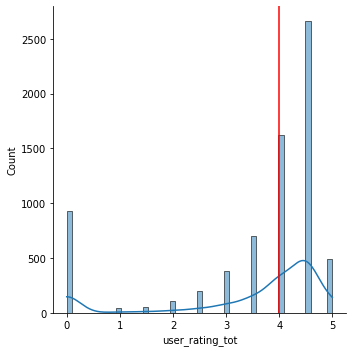

In [ ]:
# 분포확인
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data['user_rating_tot'],kde=True);
plt.axvline(4, color='red'); 

In [ ]:
# 'user_rating_tot'이 0이면 이상치로 봐서 해당 row 삭제 (어떤 회사라도 1개는 남긴다는 가정. 점수가 없다면 만들어진지 얼마 안된 어플일 것이다.)
data[data['user_rating_tot'] == 0.0]

data = data[data.user_rating_tot > 0]
data

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6,4+,Games,38,5,10,1
1,Evernote - stay organized,158578688,0.00,161065,4.0,8,4+,Productivity,37,5,23,1
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5,4+,Weather,37,5,3,1
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5,12+,Shopping,37,5,9,1
4,Bible,92774400,0.00,985920,4.5,7,4+,Reference,37,5,45,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7192,Kubik,126644224,0.00,142,4.5,1,4+,Games,38,5,1,1
7193,VR Roller-Coaster,120760320,0.00,30,4.5,0,4+,Games,38,0,1,1
7194,Bret Michaels Emojis + Lyric Keyboard,111322112,1.99,15,4.5,1,9+,Utilities,37,1,1,1
7195,VR Roller Coaster World - Virtual Reality,97235968,0.00,85,4.5,1,12+,Games,38,0,2,1


In [ ]:
## recommend 특성을 만들어 이진분류문제로 변환합니다 # 임계치로 표현
data['recommend'] = data['user_rating_tot'] > 4
data['recommend'].unique

<bound method Series.unique of 0       False
1       False
2       False
3       False
4        True
        ...  
7192     True
7193     True
7194     True
7195     True
7196     True
Name: recommend, Length: 6268, dtype: bool>

In [ ]:
# 실제 평균점수보다 높은 어플은 몇개인가? True+False = 6268
data['recommend'].value_counts()

True     3155
False    3113
Name: recommend, dtype: int64

In [ ]:
# 어플이용 연령제한
data['cont_rating'].unique()

array(['4+', '12+', '17+', '9+'], dtype=object)

훈련/검증세트로 나누기


In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, test.shape, val.shape,

((4011, 13), (1254, 13), (1003, 13))

In [ ]:
# 훈련/검증/테스트셋 나누기

train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)


target = 'recommend'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


# ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=10)
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))
print(classification_report(y_val, pipe_ord.predict(X_val)))

검증 정확도 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       491
        True       1.00      1.00      1.00       512

    accuracy                           1.00      1003
   macro avg       1.00      1.00      1.00      1003
weighted avg       1.00      1.00      1.00      1003



In [ ]:
y_val.value_counts(normalize=True)


True     0.510469
False    0.489531
Name: recommend, dtype: float64

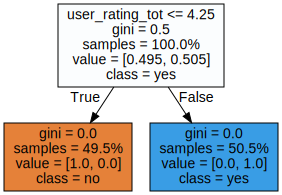

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

model_dt = pipe_ord.named_steps['decisiontreeclassifier']
enc = pipe_ord.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

### 데이터 특성 살펴보기

In [ ]:
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommend
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6,4+,Games,38,5,10,1,False
1,Evernote - stay organized,158578688,0.00,161065,4.0,8,4+,Productivity,37,5,23,1,False
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5,4+,Weather,37,5,3,1,False
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5,12+,Shopping,37,5,9,1,False
4,Bible,92774400,0.00,985920,4.5,7,4+,Reference,37,5,45,1,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6268 entries, 0 to 7196
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        6268 non-null   object 
 1   size_bytes        6268 non-null   int64  
 2   price             6268 non-null   float64
 3   rating_count_tot  6268 non-null   int64  
 4   user_rating_tot   6268 non-null   float64
 5   ver               6268 non-null   object 
 6   cont_rating       6268 non-null   object 
 7   prime_genre       6268 non-null   object 
 8   sup_devices_num   6268 non-null   int64  
 9   ipadSc_urls_num   6268 non-null   int64  
 10  lang_num          6268 non-null   int64  
 11  vpp_lic           6268 non-null   int64  
 12  recommend         6268 non-null   bool   
dtypes: bool(1), float64(2), int64(6), object(4)
memory usage: 642.7+ KB


정보누수체크

In [ ]:
data.isna().sum().sort_values()

track_name          0
size_bytes          0
price               0
rating_count_tot    0
user_rating_tot     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices_num     0
ipadSc_urls_num     0
lang_num            0
vpp_lic             0
recommend           0
dtype: int64

In [ ]:
# data 전처리

# cont_rating(연령) 안에 '+' 지우기
data['cont_rating'] = data['cont_rating'].str.split('+').str[0]

# version은 가장 앞의 차수만 남김.
data['ver'] = data['ver'].str.split('.').str[0]

# price 유료/무료로 변경 (무료: True, 유료:False)
# data['price'] = (data['price'] ==0)

# 
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommend
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6,4,Games,38,5,10,1,False
1,Evernote - stay organized,158578688,0.00,161065,4.0,8,4,Productivity,37,5,23,1,False
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5,4,Weather,37,5,3,1,False
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5,12,Shopping,37,5,9,1,False
4,Bible,92774400,0.00,985920,4.5,7,4,Reference,37,5,45,1,True


In [ ]:
#profiling

from pandas_profiling import ProfileReport
profile = ProfileReport(data, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
data.price

0       3.99
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
7192    0.00
7193    0.00
7194    1.99
7195    0.00
7196    0.00
Name: price, Length: 6268, dtype: float64

In [ ]:
data.dtypes

track_name           object
size_bytes            int64
price               float64
rating_count_tot      int64
user_rating_tot     float64
ver                  object
cont_rating          object
prime_genre          object
sup_devices_num       int64
ipadSc_urls_num       int64
lang_num              int64
vpp_lic               int64
recommend              bool
dtype: object

데이터전처리

In [ ]:
data.describe(exclude='number')

,track_name,ver,cont_rating,prime_genre,recommend
count,6268,6268,6268,6268,6268
unique,6266,56,4,23,2
top,Mannequin Challenge,1,4,Games,True
freq,2,3479,3937,3400,3155


In [ ]:
# track_name, ver의 카디널리티가 높다. (unique가 높다)
data.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
recommend,6268,2,True,3155
cont_rating,6268,4,4,3937
prime_genre,6268,23,Games,3400
ver,6268,56,1,3479
track_name,6268,6266,Mannequin Challenge,2


In [ ]:
# 카테고리를 많이 가지는 특성들의 범주 살펴보기 (# version은 의미가 없어 프라임장르로 봄.)
data['prime_genre'].value_counts() 

Games                3400
Entertainment         471
Education             387
Photo & Video         325
Utilities             219
Productivity          172
Health & Fitness      159
Music                 134
Social Networking     134
Lifestyle             113
Shopping              106
Sports                101
Finance                71
Travel                 71
Weather                66
Book                   65
News                   60
Business               53
Reference              53
Food & Drink           52
Navigation             31
Medical                20
Catalogs                5
Name: prime_genre, dtype: int64

In [ ]:
# 하이카디널리티 특성제거
data.drop(['user_rating_tot', 'track_name', 'ver', ], axis=1, inplace=True) # user_rating_tot은 recommend를 만드는 피쳐였기에 삭제함
data.head()

,size_bytes,price,rating_count_tot,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommend
0,100788224,3.99,21292,4,Games,38,5,10,1,False
1,158578688,0.00,161065,4,Productivity,37,5,23,1,False
2,100524032,0.00,188583,4,Weather,37,5,3,1,False
3,128512000,0.00,262241,12,Shopping,37,5,9,1,False
4,92774400,0.00,985920,4,Reference,37,5,45,1,True


In [ ]:
# 데이터전처리 후 trainset, testset, valset 분리
train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
# 인코더별로 특성분리
# onehot 할 특성
onehot = ['prime_genre']

# ordinal 할 특성
ordinal = ['size_bytes', 'price', 'rating_count_tot', 'cont_rating', 'sup_devices_num', 'ipadSc_urls_num', 'lang_num', 'vpp_lic', 'recommend']

In [ ]:
# 컬럼갯수와 인코더별 구분한 컬럼 수가 같은지 확인
len(data.columns) == len(ordinal) + len(onehot)

True

In [ ]:
target = 'recommend'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
# 특성중요도 = 지니불순도가 가장 많이 감소함

In [ ]:
# xgboost
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(random_state=2)
)

pipe.fit(X_train, y_train);

from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.6181455633100698
              precision    recall  f1-score   support

       False       0.68      0.60      0.64       564
        True       0.55      0.65      0.60       439

    accuracy                           0.62      1003
   macro avg       0.62      0.62      0.62      1003
weighted avg       0.63      0.62      0.62      1003



검증 정확도 0.5453639082751744
              precision    recall  f1-score   support

       False       0.53      0.57      0.55       491
        True       0.56      0.52      0.54       512

    accuracy                           0.55      1003
   macro avg       0.55      0.55      0.55      1003
weighted avg       0.55      0.55      0.55      1003



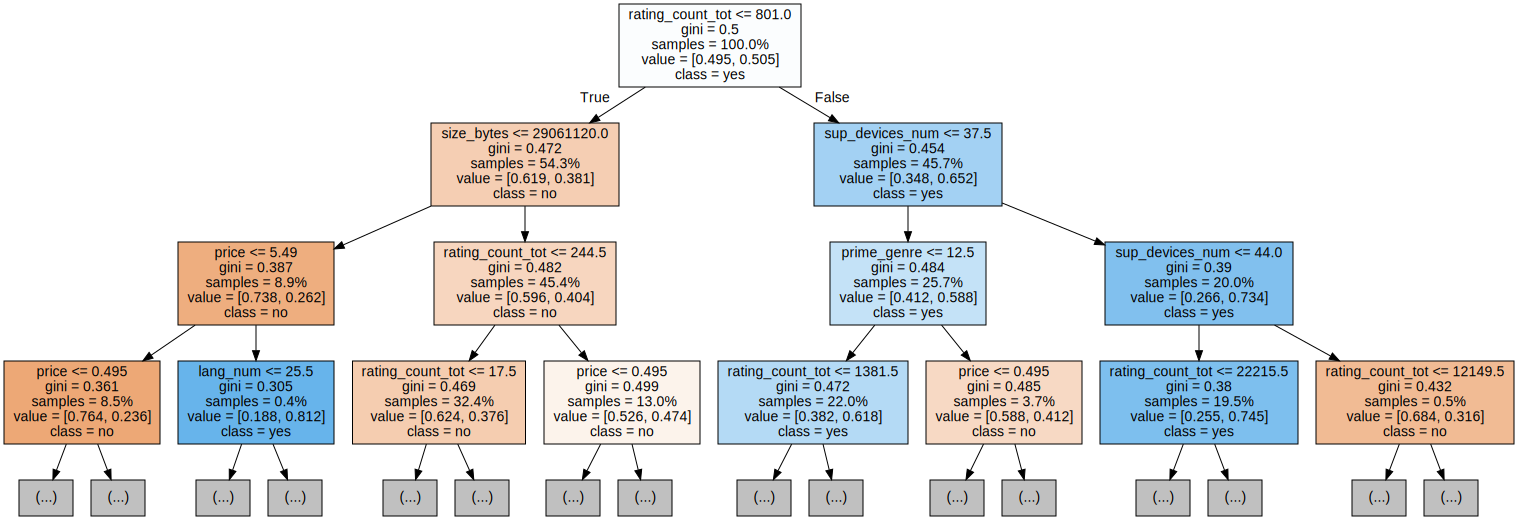

In [ ]:
# 전처리된 데이터 기준으로 decision tree  돌려보기.

target = 'recommend'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


# DecisionTree ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=10) # maxdepth 안하는게 더 성능이 좋음. 검증도가 0.6정도 차이남
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))
print(classification_report(y_val, pipe_ord.predict(X_val)))



import graphviz
from sklearn.tree import export_graphviz

model_dt = pipe_ord.named_steps['decisiontreeclassifier']
enc = pipe_ord.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

In [ ]:
model_dt = pipe_ord.named_steps['decisiontreeclassifier']

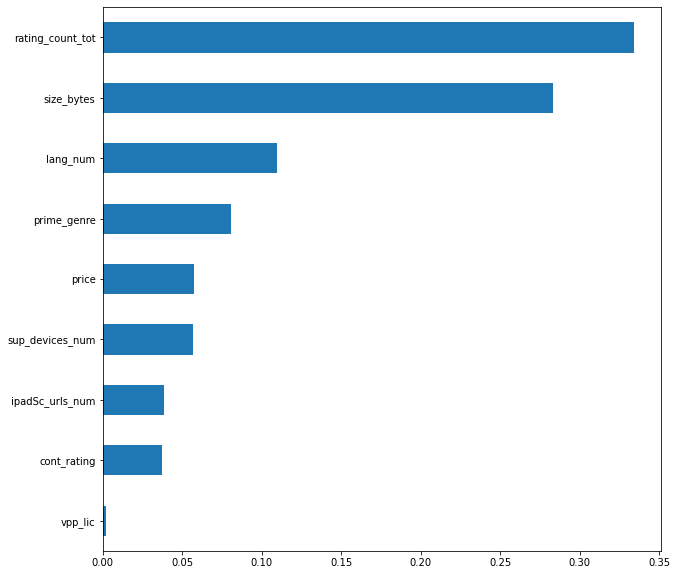

In [ ]:
# 결정트리에서의 특성중요도
importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();


In [ ]:
column  = 'rating_count_tot'

# 'rating_count_tot' 없이 fit
pipe = make_pipeline(OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2))

pipe.fit(X_train.drop(columns=column), y_train)
score_without = pipe.score(X_val.drop(columns=column), y_val)
print(f'검증 정확도 ({column} 제외): {score_without}')

# 'rating_count_tot' 포함 후 다시 학습
pipe = make_pipeline(OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2))
pipe.fit(X_train, y_train)
score_with = pipe.score(X_val, y_val)
print(f'검증 정확도 ({column} 포함): {score_with}')

# 'rating_count_tot' 포함 전 후 정확도 차이를 계산
print(f'{column}의 Drop-Column 중요도: {score_with - score_without}')

검증 정확도 (rating_count_tot 제외): 0.5124626121635095
검증 정확도 (rating_count_tot 포함): 0.5473579262213359
rating_count_tot의 Drop-Column 중요도: 0.03489531405782642


In [ ]:
# 최적의 Deccisiontree에 test값 넣기
y_test_pred = pipe.predict(X_test)
print(accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred))

0.5685805422647527 0.5756862745098039


In [ ]:
# randomforest_ordinal encoding
pipe_ord = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    SimpleImputer(), 
    RandomForestClassifier(random_state=10) 
)

pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))
print(classification_report(y_val, pipe_ord.predict(X_val)))

검증 정확도 0.6111665004985045
              precision    recall  f1-score   support

       False       0.59      0.65      0.62       491
        True       0.63      0.58      0.60       512

    accuracy                           0.61      1003
   macro avg       0.61      0.61      0.61      1003
weighted avg       0.61      0.61      0.61      1003



In [ ]:
column  = 'rating_count_tot'

# 'rating_count_tot' 없이 fit
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

pipe.fit(X_train.drop(columns=column), y_train)
score_without = pipe.score(X_val.drop(columns=column), y_val)
print(f'검증 정확도 ({column} 제외): {score_without}')

# 'rating_count_tot' 포함 후 다시 학습
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)
pipe.fit(X_train, y_train)
score_with = pipe.score(X_val, y_val)
print(f'검증 정확도 ({column} 포함): {score_with}')

# 'rating_count_tot' 포함 전 후 정확도 차이를 계산합니다
print(f'{column}의 Drop-Column 중요도: {score_with - score_without}')

검증 정확도 (rating_count_tot 제외): 0.5832502492522432
검증 정확도 (rating_count_tot 포함): 0.6191425722831505
rating_count_tot의 Drop-Column 중요도: 0.03589232303090728


In [ ]:
# 특성중요도(순열중요도 Permutation Importance, Mean)

# 변경 할 특성을 선택합니다
feature = ['rating_count_tot', 'size_bytes']
X_val[feature].head()

# 특성의 분포를 확인합니다
X_val[feature].value_counts()

# 특성의 값을 무작위로 섞습니다
X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.RandomState(seed=7).permutation(X_val_permuted[feature])

# 특성 값의 순서가 뒤바뀐 것을 확인합니다
X_val_permuted[feature].head()

# 카테고리들의 분포는 바뀌지는 않았음을 확인합니다
X_val_permuted[feature].value_counts()

# 순열 중요도 값을 얻습니다. (재학습이 필요 없습니다!)
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')

# feature 에 대해서 순열 중요도를 계산해 봅시다

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val_permuted[feature])
score_permuted = pipe.score(X_val_permuted, y_val)

print(f'검증 정확도 ({feature}): {score_with}')
print(f'검증 정확도 (permuted "{feature}"): {score_permuted}')
print(f'순열 중요도: {score_with - score_permuted}')

검증 정확도 (['rating_count_tot', 'size_bytes']): 0.6191425722831505
검증 정확도 (permuted "['rating_count_tot', 'size_bytes']"): 0.5503489531405783
순열 중요도: 0.0687936191425722
검증 정확도 (['rating_count_tot', 'size_bytes']): 0.6191425722831505
검증 정확도 (permuted "['rating_count_tot', 'size_bytes']"): 0.5373878364905285
순열 중요도: 0.08175473579262205


In [ ]:
# xgboost
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200, random_state=2, n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);

from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.6321036889332003
              precision    recall  f1-score   support

       False       0.67      0.61      0.64       534
        True       0.60      0.65      0.62       469

    accuracy                           0.63      1003
   macro avg       0.63      0.63      0.63      1003
weighted avg       0.64      0.63      0.63      1003



In [ ]:
# 랜덤포레스트 ordinalencoder pipeline
pipe_ord = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)
)

# train 학습, 검증셋 정확도
pipe_ord.fit(X_train, y_train)
print('검증 정확도', pipe_ord.score(X_val, y_val))

print(classification_report(y_val, pipe_ord.predict(X_val)))

검증 정확도 0.617148554336989
              precision    recall  f1-score   support

       False       0.60      0.68      0.63       491
        True       0.64      0.56      0.60       512

    accuracy                           0.62      1003
   macro avg       0.62      0.62      0.62      1003
weighted avg       0.62      0.62      0.62      1003



findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


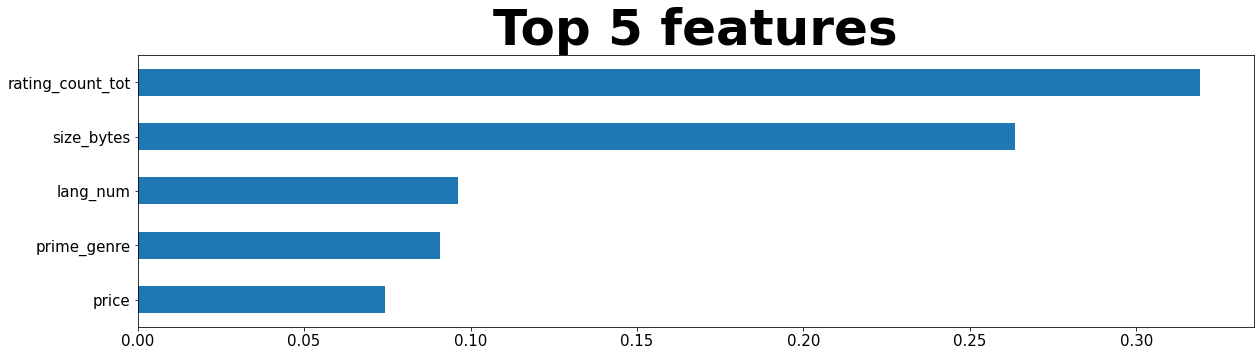

In [ ]:
# 특성 중요도(Feature Importances(Mean decrease impurity, MDI))
rf = pipe_ord.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

# 폰트사이즈
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15

n = 5

plt.figure(figsize=(20, 5))
plt.title(f'Top {n} features', size=50, weight='bold')
importances.sort_values()[-n:].plot.barh();


순열중요도 사용하여 하이퍼파라미터로 튜닝




In [ ]:
# eli5 라이브러리 사용해서 순열중요도 계산

from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) ])

# pipeline 생성을 확인
pipe.named_steps


{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=2)}

In [ ]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.6191425722831505


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()


vpp_lic            -0.001196
ipadSc_urls_num    -0.000997
cont_rating         0.005184
price               0.008574
size_bytes          0.012363
sup_devices_num     0.013161
lang_num            0.014158
prime_genre         0.019741
rating_count_tot    0.058824
dtype: float64

In [ ]:
# 특성별 score 확인
eli5.show_weights(permuter, top=5, # top = None, 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 함
)

In [ ]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (4011, 9) (1003, 9)


In [ ]:
# 중요도 이용하여 특성선택
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance # Feature importance가 -인것들은 모델 성능에 별로 영향을 안주는 것으로 삭제해도 좋음
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (4011, 7) (1003, 7)


In [ ]:
# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe.fit(X_train_selected, y_train);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing rf, total=   0.9s


In [ ]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.6301096709870389


In [ ]:
# 순열 중요도의 평균 감소값과 그 표준편차의 차가 양수인 특징들을 확인할 수 있습니다.
permuter.feature_importances_ - permuter.feature_importances_std_ > 0

array([ True, False,  True,  True,  True,  True, False,  True, False])

In [ ]:
###### pipe라인 랜덤포레스트 모델의 파라미터튜닝
pipe = make_pipeline(
      TargetEncoder(min_samples_leaf=1, smoothing=1), # TargetEncoder = 범주형 변수 인코더, 타겟값을 특성의 범주별로 평균값을 구한 다음, 그 값으로 인코딩
      SimpleImputer(), # simpleimputer = 결측값을 대치, 결측치 없음.
      RandomForestClassifier(max_depth = 10, n_jobs=-1, random_state=2)) # max_depth: 트리깊이

# 튜닝할 하이퍼파라미터의 범위를 지정
parameters = {'randomforestclassifier__max_depth': range(1, 5, 2), 
              'randomforestclassifier__max_features': range(1, 5, 2), 
              'randomforestclassifier__min_samples_leaf' : range(1, 5, 2)}
    
# 최적의 하이퍼파라미터값 찾아주는거 = RandomizedSearchCV
rf_classifier = RandomizedSearchCV(pipe, 
                                    param_distributions=parameters, #  param_distributions : 사전/사전목록
                                    n_iter=10, # 정수, 기본값=10
                                    cv=5, # 교차검증생성기 또는 반복가능 default=None
                                    scoring='accuracy', # 평가방법
                                    verbose=1) # 진행상황표시. 높을수록 더 많은 메세지표시.
rf_classifier.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
# RandomCV 결과 확인
print('Best Parameters: ', rf_classifier.best_params_)
print('검증정확도: ', rf_classifier.best_score_)

Best Parameters:  {'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__max_depth': 3}
검증정확도:  0.6524585174672286


In [ ]:
# 최적의 랜덤포레스트에 val값 넣기
y_val_pred = rf_classifier.predict(X_val)
print(accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred))

0.617148554336989 0.5733333333333334


In [ ]:
# 최적의 랜덤포레스트에 test값 넣기
y_test_pred = rf_classifier.predict(X_test)
print(accuracy_score(y_test, y_test_pred),f1_score(y_test, y_test_pred))

0.6483253588516746 0.6016260162601624


In [ ]:
# eli5 라이브러리 사용해서 순열중요도 계산

from sklearn.pipeline import Pipeline
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

# pipeline 생성을 확인합니다.
pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=2)}

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


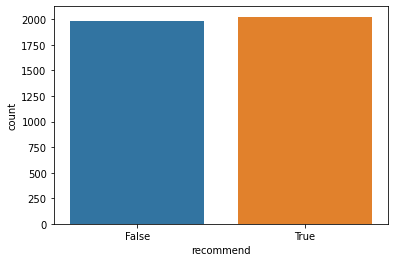

In [ ]:
# pdp 전 분포도보기

%matplotlib inline
import seaborn as sns
sns.countplot(y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


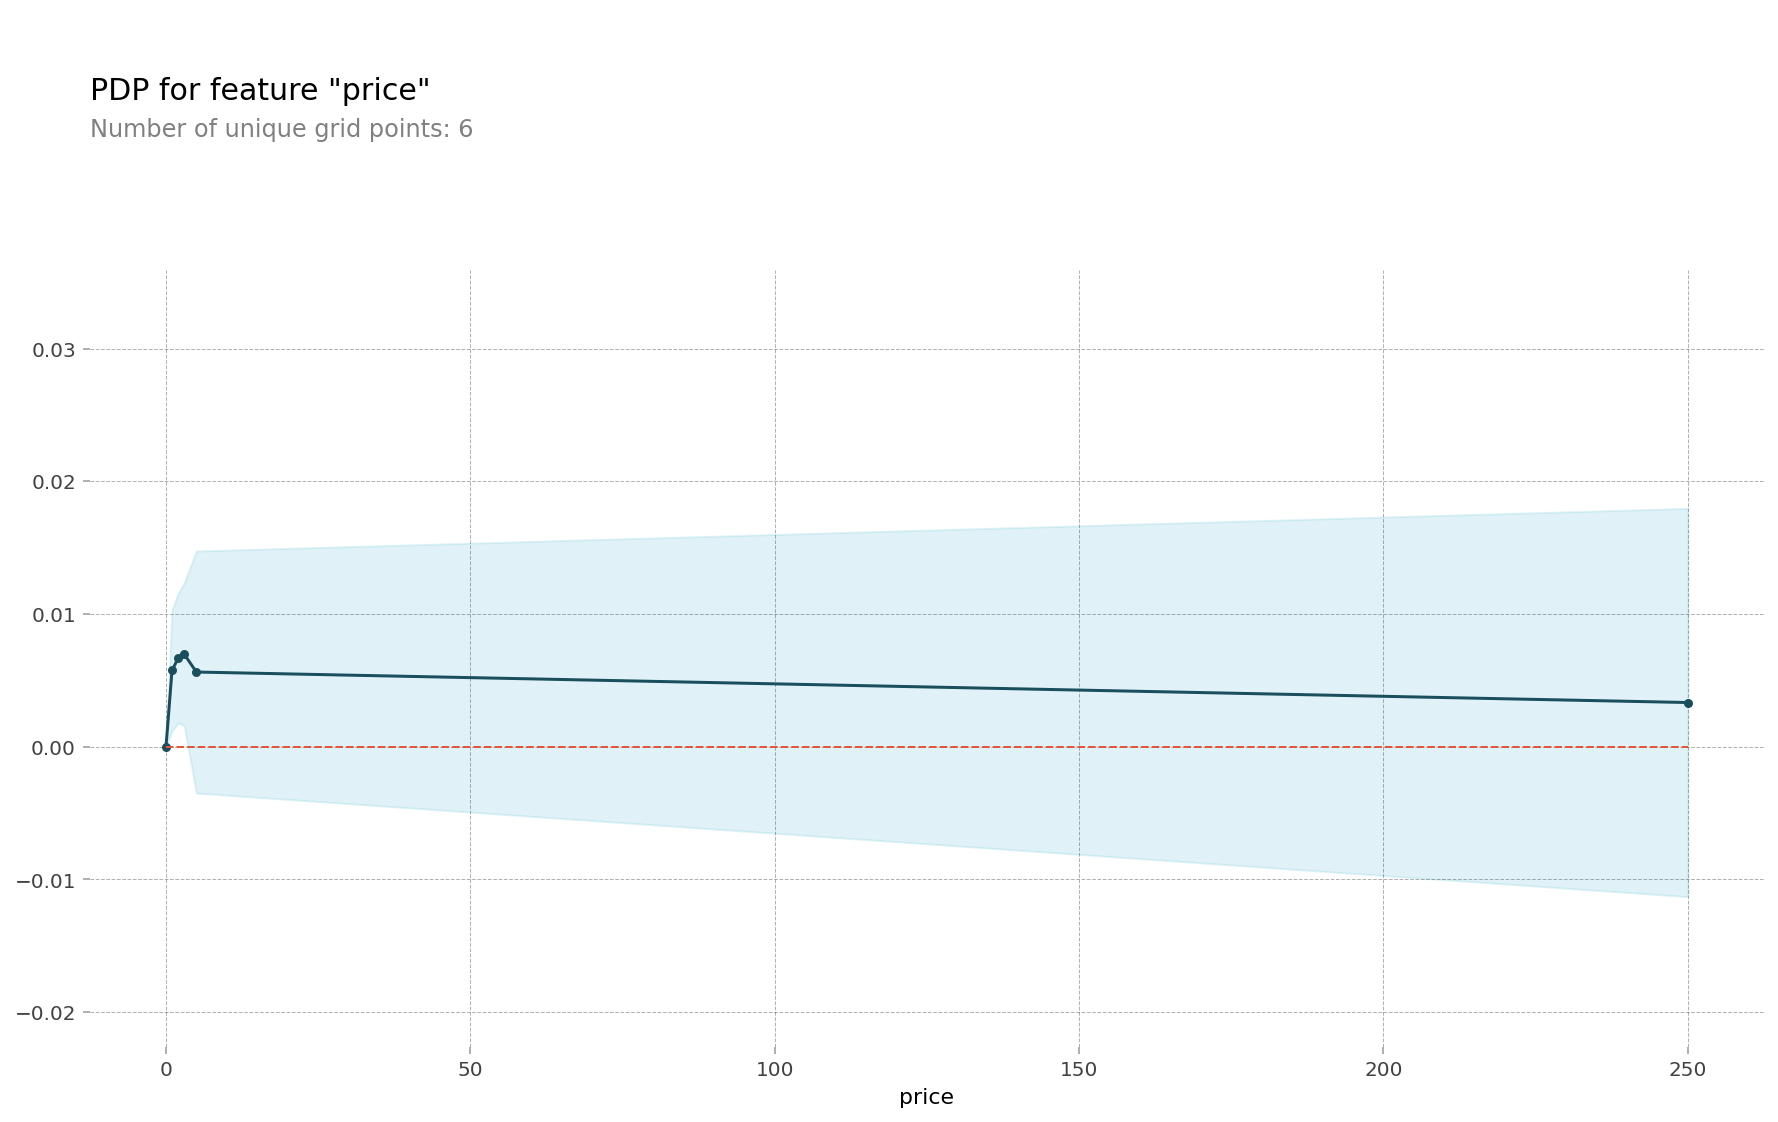

In [ ]:
# dpi(dots per inch) 수치조정-> 이미지 화질조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'price'

isolated = pdp_isolate(
    model=rf_classifier.fit(X_train, y_train),
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

# 금액이 

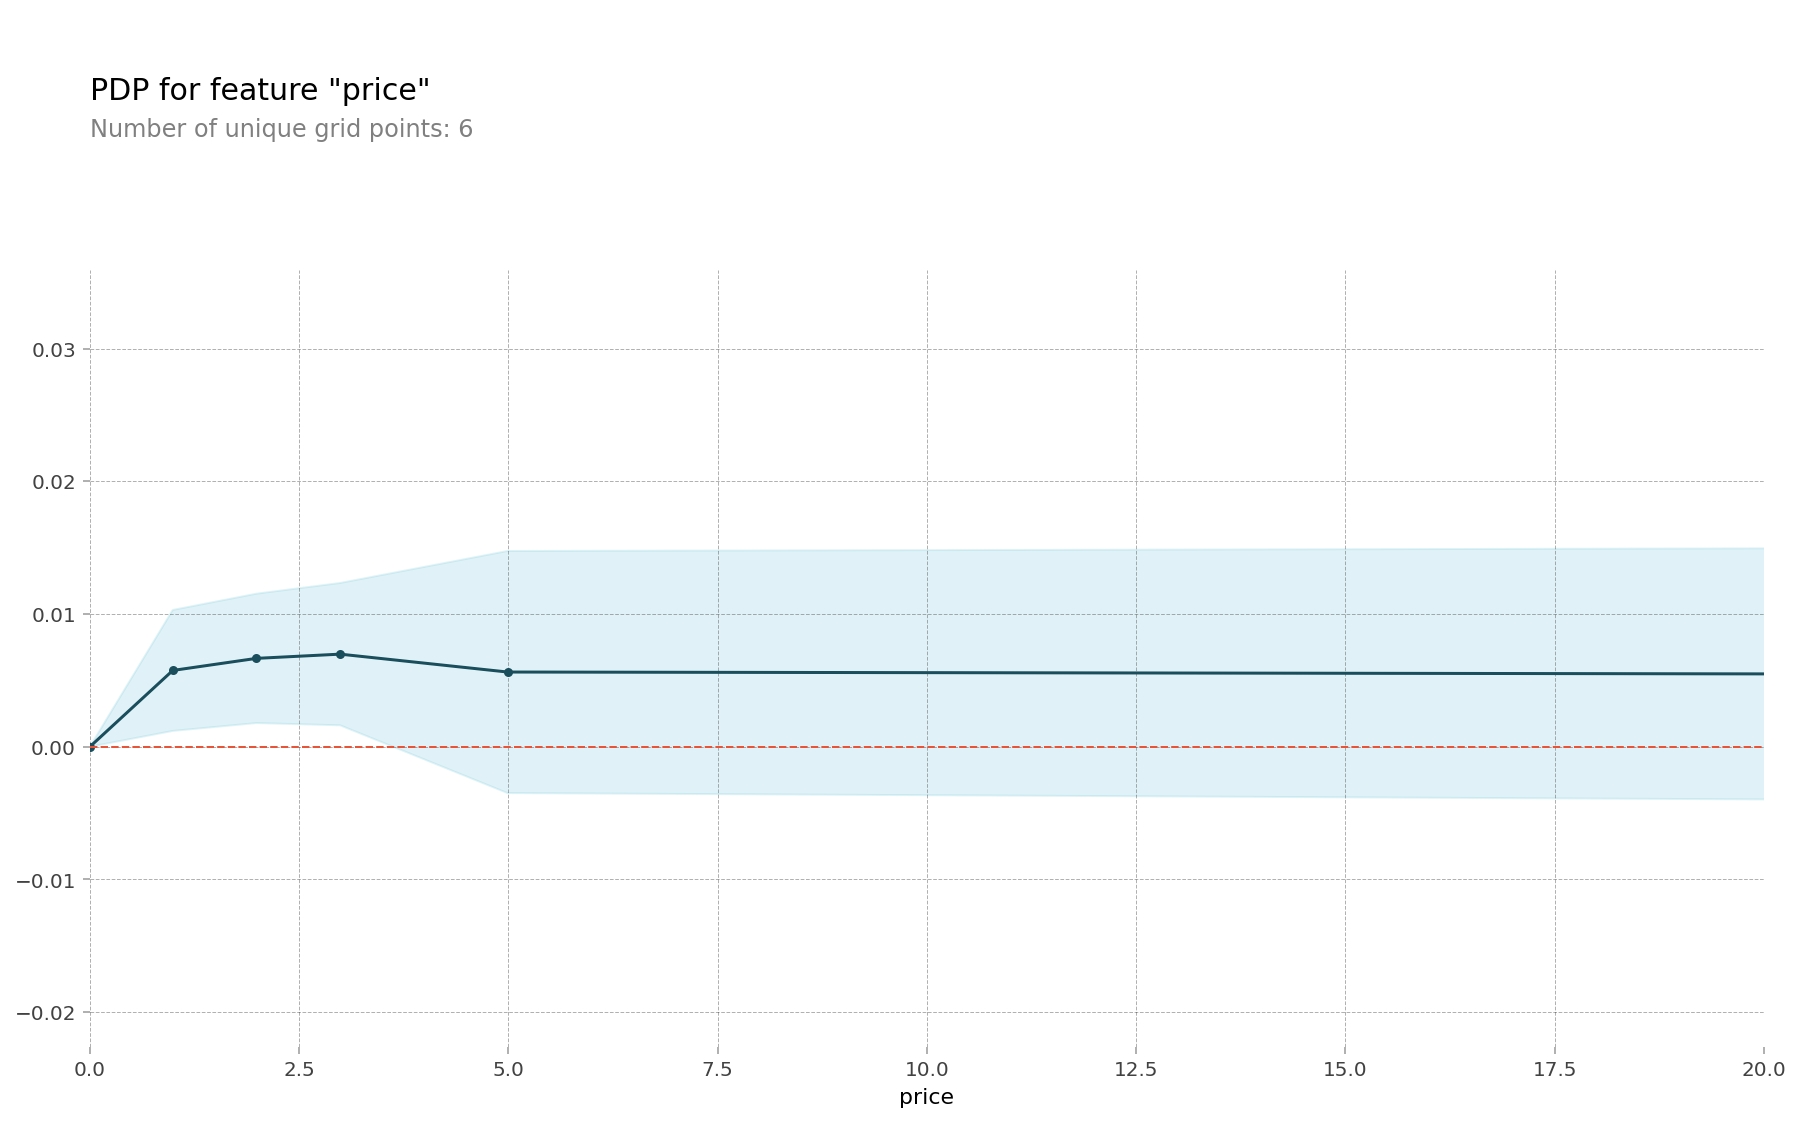

In [ ]:
# 0달러~20달러 구간 확대
pdp_plot(isolated, feature_name=feature)
plt.xlim((0,20));
# 약 3달러까지는 가격이 높을수록 평점에 좋음.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


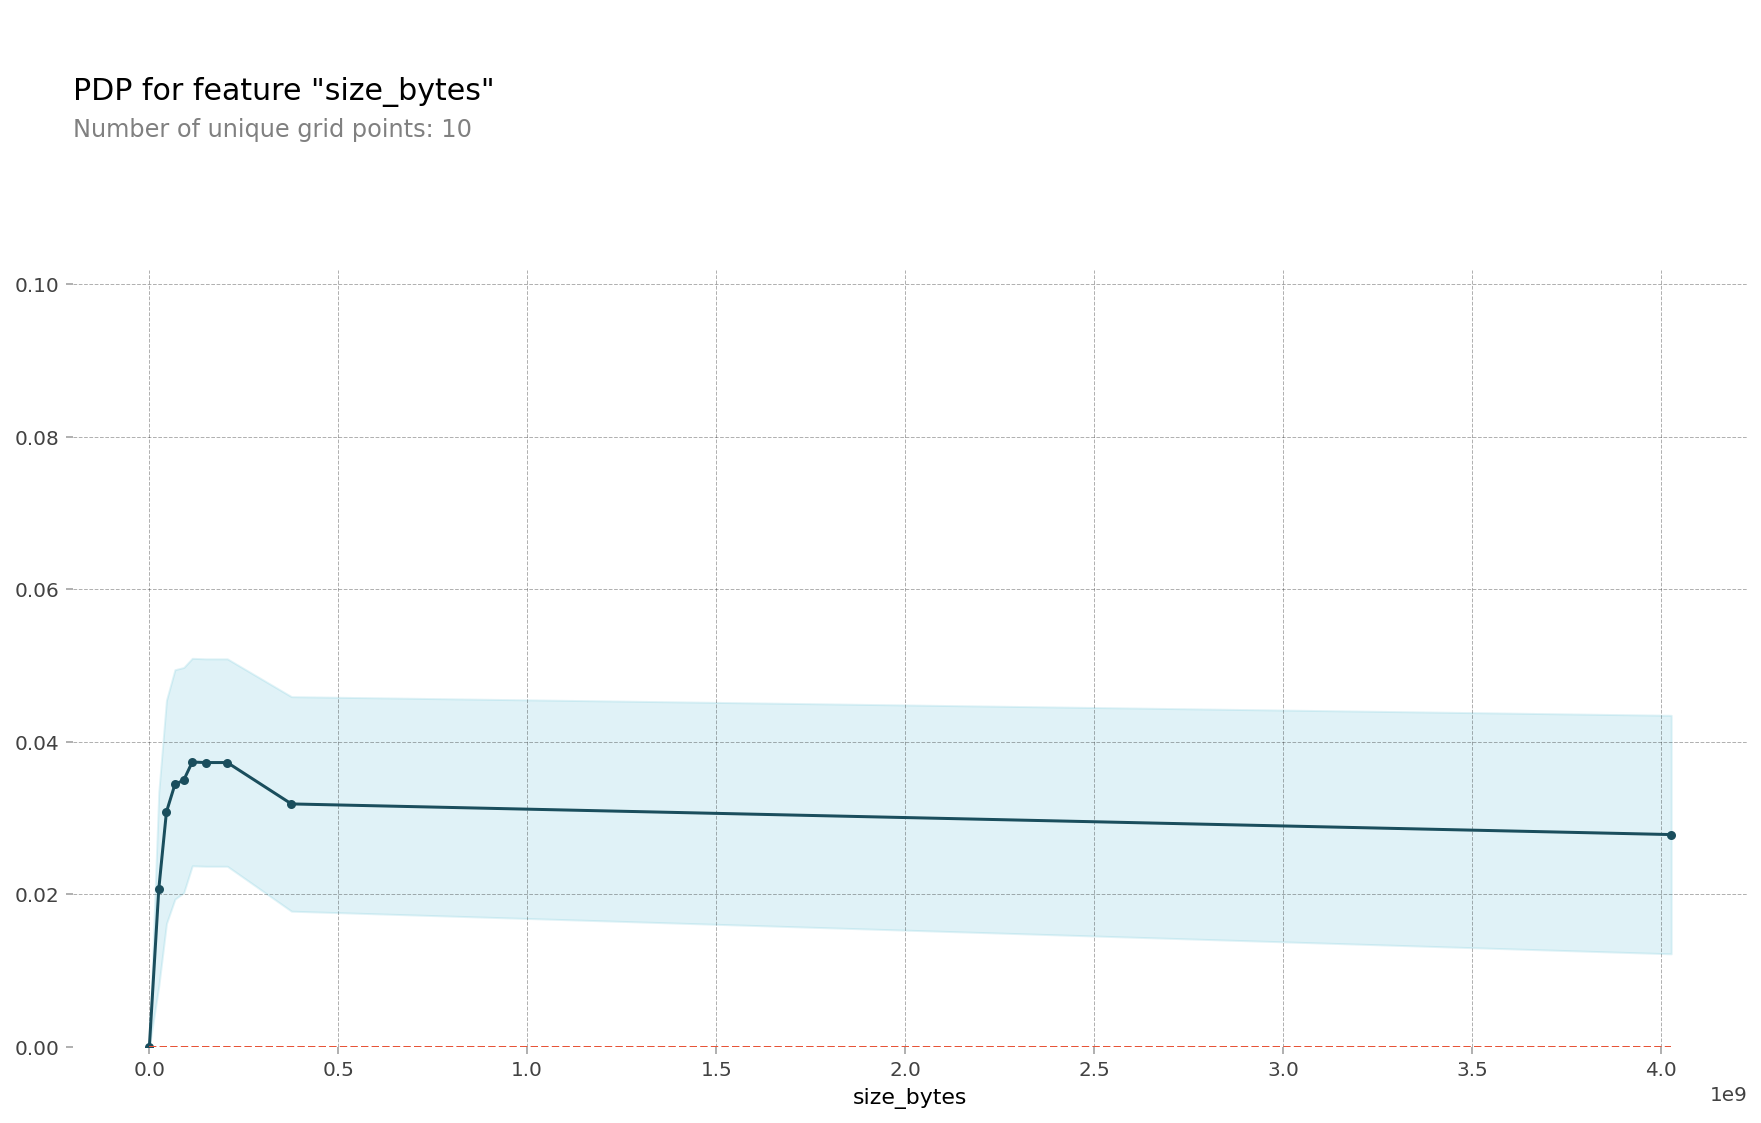

In [ ]:
# dpi(dots per inch) 수치조정-> 이미지 화질조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'size_bytes'

isolated = pdp_isolate(
    model=rf_classifier.fit(X_train, y_train),
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);


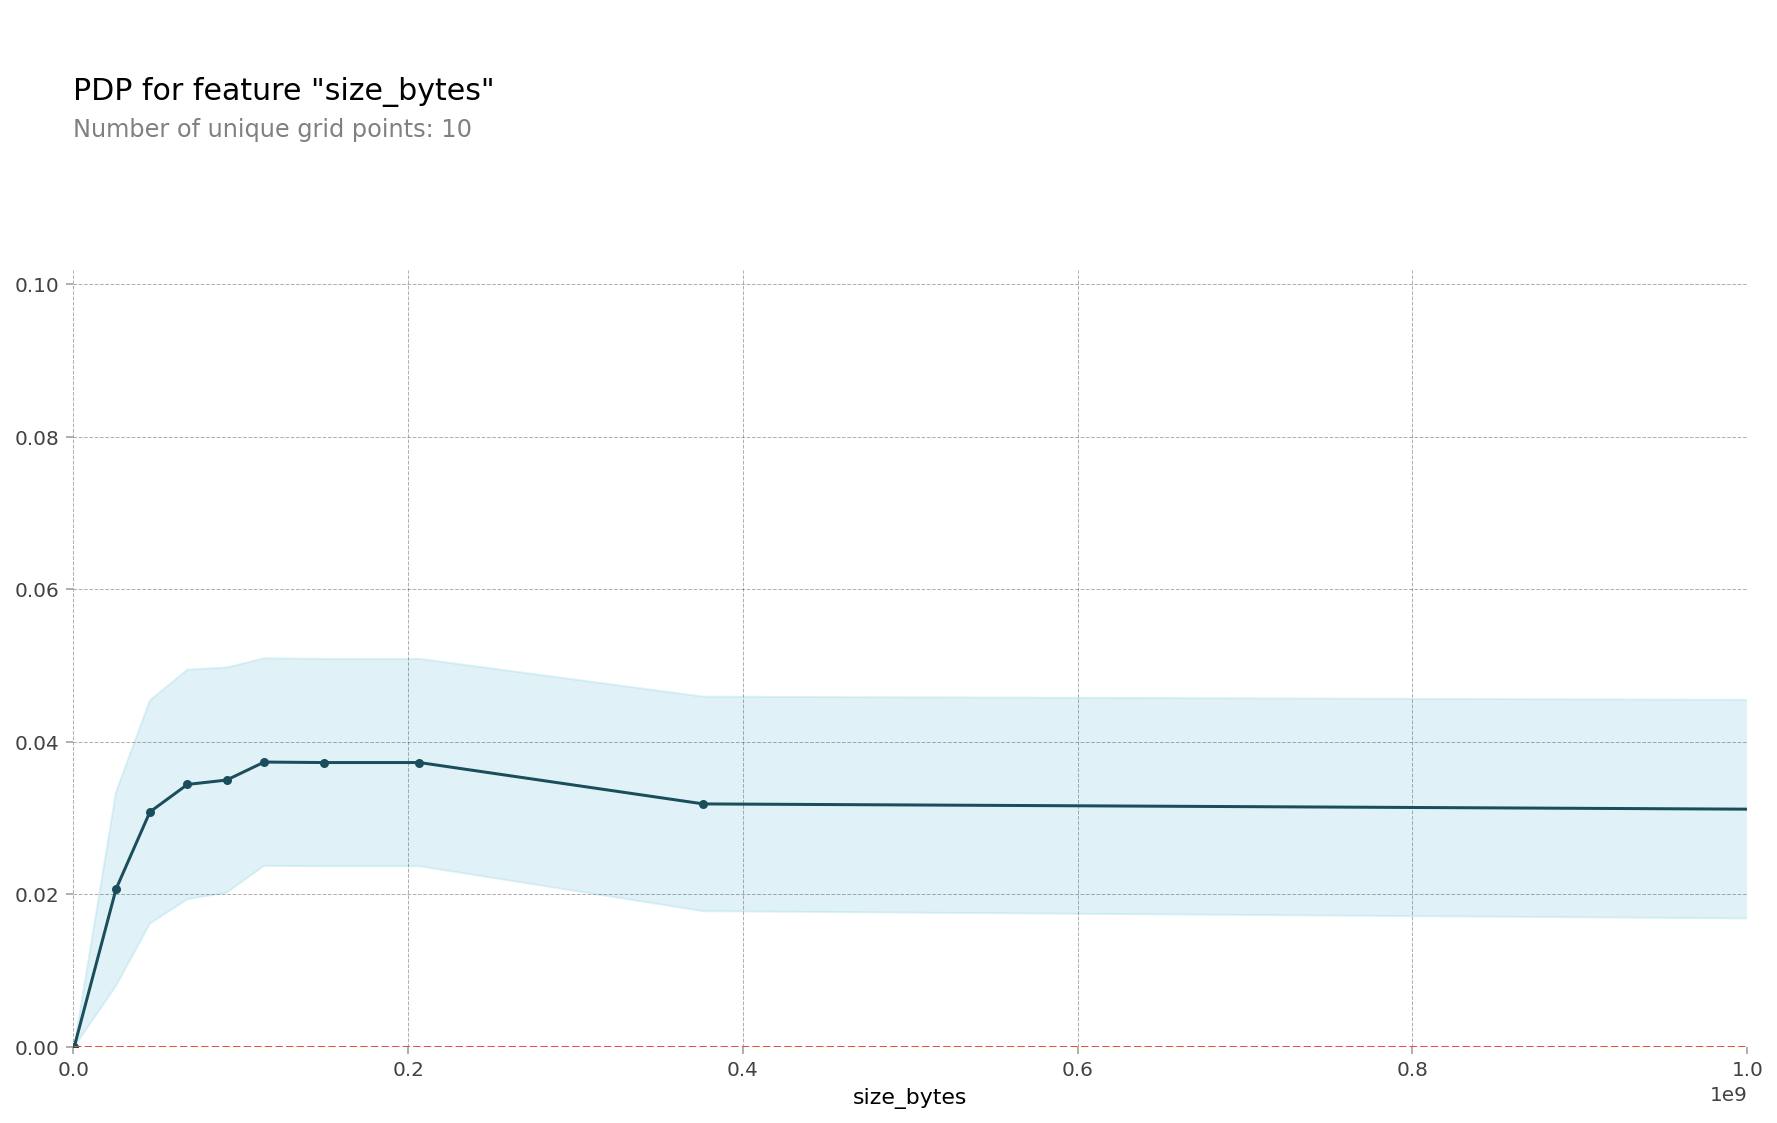

In [ ]:
# 0~1,000,000,000 구간 확대
pdp_plot(isolated, feature_name=feature)
plt.xlim((0,1000000000)); # 1억만bytes(95MB)까지는 사이즈가 큰 것이 평점에도 좋음

Fitting 5 folds for each of 8 candidates, totalling 40 fits


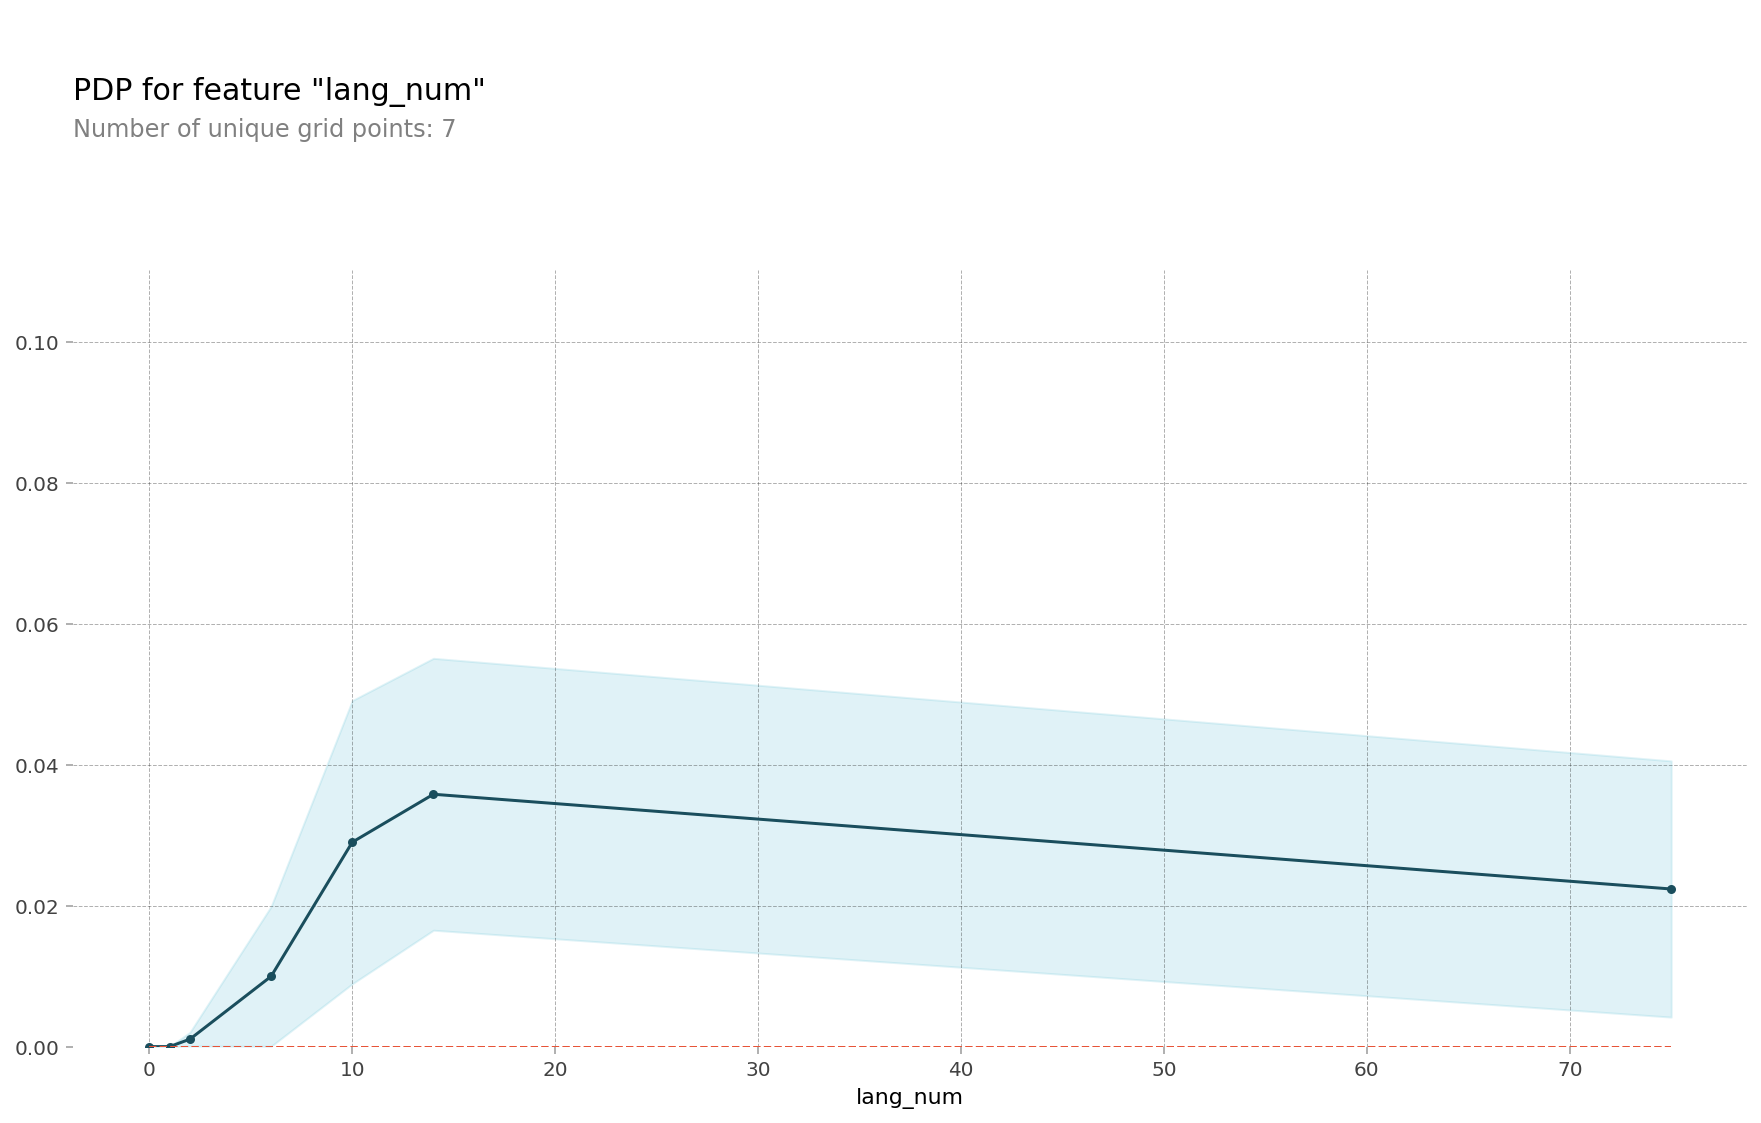

In [ ]:
# dpi(dots per inch) 수치조정-> 이미지 화질조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'lang_num'

isolated = pdp_isolate(
    model=rf_classifier.fit(X_train, y_train),
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);


Fitting 5 folds for each of 8 candidates, totalling 40 fits


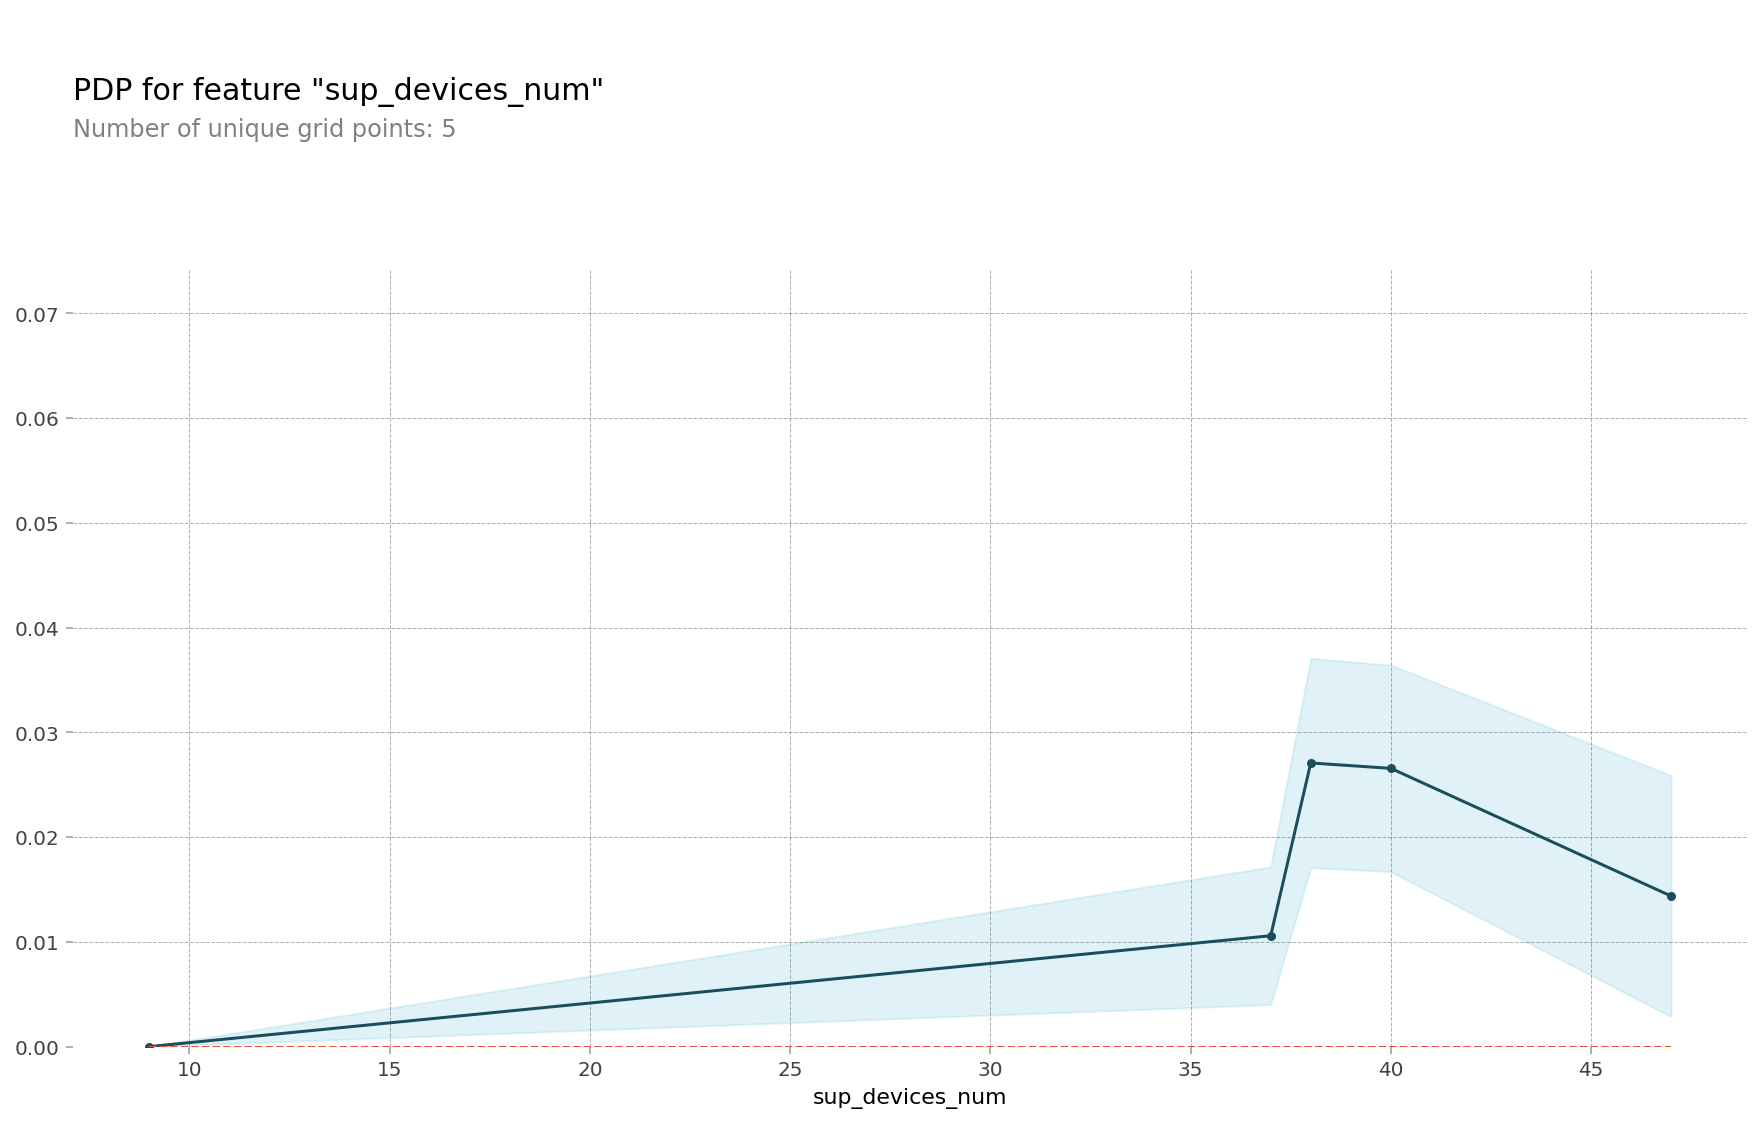

In [ ]:
# dpi(dots per inch) 수치조정-> 이미지 화질조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'sup_devices_num'

isolated = pdp_isolate(
    model=rf_classifier.fit(X_train, y_train),
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);
